# Constructing our Minimum-Covariance Portfolios

We will be constructing our portfolios by selecting the assets which have the lowest correlations between each other. We will rebalance semi-annually based on these selections, and at each rebalance, ensure that our portfolio is split among the two geographies 50/50 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Preprocessing

In [2]:
# Remove 1st line since they are pct changes, therefore have
# NaNs in the first row
rets = pd.read_csv("returns.csv")[1:]
rets.head()

,Date,USA_EWJ,USA_EWT,USA_MCHI,USA_EWY,USA_EWZ,USA_INDA,USA_ACWV,USA_IDV,USA_EWC,...,CAN_HULC.TO,CAN_HMUS.TO,CAN_HSUV.TO,USA_CNY=X,USA_BRL=X,USA_ZAR=X,USA_RUB=X,USA_EUR=X,USA_JPY=X,USA_MXN=X
1,2011-01-04,0.000804,-0.007407,NaN,0.002263,0.004396,NaN,NaN,-0.009259,-0.010412,...,NaN,NaN,NaN,-0.001760,0.019189,0.006326,0.0,0.000134,0.006743,-0.000384
2,2011-01-05,-0.007231,-0.016584,NaN,0.000376,-0.011616,NaN,NaN,-0.002596,0.002023,...,NaN,NaN,NaN,0.002584,0.012754,0.003853,0.0,0.002671,0.004506,-0.004249
3,2011-01-06,0.000000,-0.002108,NaN,-0.006960,-0.010049,NaN,NaN,-0.009891,-0.004847,...,NaN,NaN,NaN,-0.002956,0.004498,0.008670,0.0,0.012522,0.014030,0.003119
4,2011-01-07,0.003777,-0.015632,NaN,0.005493,-0.009119,NaN,NaN,-0.005258,0.000406,...,NaN,NaN,NaN,0.005929,0.006507,0.012983,0.0,0.013551,0.001334,0.000573
5,2011-01-10,0.000000,0.002146,NaN,-0.014883,-0.010071,NaN,NaN,0.000529,-0.003651,...,NaN,NaN,NaN,0.000151,-0.029895,-0.000295,0.0,0.006620,-0.003241,-0.001063


In [3]:
# Reindex to date
rets.index = pd.to_datetime(rets['Date'])
del rets['Date']
rets.head()

,USA_EWJ,USA_EWT,USA_MCHI,USA_EWY,USA_EWZ,USA_INDA,USA_ACWV,USA_IDV,USA_EWC,USA_EWU,...,CAN_HULC.TO,CAN_HMUS.TO,CAN_HSUV.TO,USA_CNY=X,USA_BRL=X,USA_ZAR=X,USA_RUB=X,USA_EUR=X,USA_JPY=X,USA_MXN=X
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-04,0.000804,-0.007407,NaN,0.002263,0.004396,NaN,NaN,-0.009259,-0.010412,0.010462,...,NaN,NaN,NaN,-0.001760,0.019189,0.006326,0.0,0.000134,0.006743,-0.000384
2011-01-05,-0.007231,-0.016584,NaN,0.000376,-0.011616,NaN,NaN,-0.002596,0.002023,-0.002157,...,NaN,NaN,NaN,0.002584,0.012754,0.003853,0.0,0.002671,0.004506,-0.004249
2011-01-06,0.000000,-0.002108,NaN,-0.006960,-0.010049,NaN,NaN,-0.009891,-0.004847,-0.008647,...,NaN,NaN,NaN,-0.002956,0.004498,0.008670,0.0,0.012522,0.014030,0.003119
2011-01-07,0.003777,-0.015632,NaN,0.005493,-0.009119,NaN,NaN,-0.005258,0.000406,-0.003925,...,NaN,NaN,NaN,0.005929,0.006507,0.012983,0.0,0.013551,0.001334,0.000573
2011-01-10,0.000000,0.002146,NaN,-0.014883,-0.010071,NaN,NaN,0.000529,-0.003651,0.001751,...,NaN,NaN,NaN,0.000151,-0.029895,-0.000295,0.0,0.006620,-0.003241,-0.001063


In [4]:
# Delete any outliers
rets[rets > 1] = 0
rets[rets < -1] = 0


In [5]:
sum(rets["USA_RUB=X"] > 100)

0

In [6]:
rets.index

DatetimeIndex(['2011-01-04', '2011-01-05', '2011-01-06', '2011-01-07',
               '2011-01-10', '2011-01-11', '2011-01-12', '2011-01-13',
               '2011-01-14', '2011-01-17',
               ...
               '2021-06-22', '2021-06-23', '2021-06-24', '2021-06-25',
               '2021-06-28', '2021-06-29', '2021-06-30', '2021-07-01',
               '2021-07-02', '2021-07-05'],
              dtype='datetime64[ns]', name='Date', length=2740, freq=None)

In [7]:
# Create a list of semiannual dates to split on
dates_to_split = pd.date_range(rets.index[0], rets.index[-1], freq='6M')
dates_to_split

DatetimeIndex(['2011-01-31', '2011-07-31', '2012-01-31', '2012-07-31',
               '2013-01-31', '2013-07-31', '2014-01-31', '2014-07-31',
               '2015-01-31', '2015-07-31', '2016-01-31', '2016-07-31',
               '2017-01-31', '2017-07-31', '2018-01-31', '2018-07-31',
               '2019-01-31', '2019-07-31', '2020-01-31', '2020-07-31',
               '2021-01-31'],
              dtype='datetime64[ns]', freq='6M')

In [8]:
# Split on these dates
semiannual = {}

for i in range(len(dates_to_split)-1):
    #print(dates_to_split[i+1])
    semiannual[i] = rets[dates_to_split[i]:dates_to_split[i+1]]

In [9]:
# Sanity check
print(semiannual[0].index[0],semiannual[0].index[-1])

2011-01-31 00:00:00 2011-07-29 00:00:00


In [10]:
# Sanity check
print(semiannual[1].index[0],semiannual[1].index[-1])

2011-08-01 00:00:00 2012-01-31 00:00:00


In [11]:
# Sanity check
print(semiannual[19].index[0],semiannual[19].index[-1])

2020-07-31 00:00:00 2021-01-29 00:00:00


# Lowest correlation Search

In [12]:
# For each group of 6mo, find the assets with lowest avg correlation
corrs = semiannual[10].corr().abs().mean(axis=1)
corrs

USA_EWJ      0.435156
USA_EWT      0.511699
USA_MCHI     0.528725
USA_EWY      0.541586
USA_EWZ      0.432182
               ...   
USA_ZAR=X    0.118197
USA_RUB=X    0.084428
USA_EUR=X    0.151444
USA_JPY=X    0.082320
USA_MXN=X    0.462142
Length: 128, dtype: float64

In [13]:
# Sort those values to see which ones have lowest correlation
corrs.sort_values(axis=0)[:30]

CAN_XFR.TO    0.075507
CAN_CMR.TO    0.081464
USA_JPY=X     0.082320
USA_RUB=X     0.084428
USA_BRL=X     0.085703
CAN_HXQ.TO    0.097759
CAN_HHF.TO    0.113232
CAN_CBO.TO    0.113303
USA_ZAR=X     0.118197
USA_CNY=X     0.120320
CAN_HUZ.TO    0.144101
USA_EUR=X     0.151444
CAN_XSC.TO    0.154957
CAN_SVR.TO    0.162192
CAN_HXF.TO    0.165272
CAN_XGD.TO    0.181217
CAN_HUN.TO    0.185430
CAN_XIG.TO    0.186638
CAN_CVD.TO    0.190808
USA_KSA       0.198407
CAN_CBH.TO    0.199100
CAN_HUG.TO    0.208522
CAN_HTB.TO    0.237717
CAN_XUU.TO    0.248717
CAN_CGL.TO    0.253634
CAN_CLF.TO    0.280254
CAN_CGR.TO    0.283629
CAN_CLG.TO    0.284980
CAN_HXE.TO    0.285884
USA_QAT       0.286492
dtype: float64

In [14]:
# First 15 CAN values
[x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:15]

['CAN_XFR.TO',
 'CAN_CMR.TO',
 'CAN_HXQ.TO',
 'CAN_HHF.TO',
 'CAN_CBO.TO',
 'CAN_HUZ.TO',
 'CAN_XSC.TO',
 'CAN_SVR.TO',
 'CAN_HXF.TO',
 'CAN_XGD.TO',
 'CAN_HUN.TO',
 'CAN_XIG.TO',
 'CAN_CVD.TO',
 'CAN_CBH.TO',
 'CAN_HUG.TO']

In [15]:
# Loop through each semiannual period, save the 30 Canadian and USA assets with the
# lowest average correlation
top15 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top15[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:30]
    top15[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:30]
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [16]:
# Sanity check
top15[1]

['USA_JPY=X',
 'USA_ZAR=X',
 'USA_RUB=X',
 'USA_BRL=X',
 'USA_EUR=X',
 'USA_CNY=X',
 'USA_EPU',
 'USA_TUR',
 'USA_EPHE',
 'USA_ECH',
 'USA_EWJ',
 'USA_THD',
 'USA_EIRL',
 'USA_EIDO',
 'USA_MCHI',
 'USA_EIS',
 'USA_EWZ',
 'USA_EWH',
 'USA_ERUS',
 'USA_MXN=X',
 'USA_ENZL',
 'USA_EWL',
 'USA_EWT',
 'USA_EWW',
 'USA_EWY',
 'USA_EWM',
 'USA_EWP',
 'USA_EWS',
 'USA_EPOL',
 'USA_EZA',
 'CAN_CMR.TO',
 'CAN_HUN.TO',
 'CAN_CVD.TO',
 'CAN_CGL.TO',
 'CAN_HUG.TO',
 'CAN_XIG.TO',
 'CAN_CGR.TO',
 'CAN_DLR.TO',
 'CAN_XGD.TO',
 'CAN_HUC.TO',
 'CAN_CBO.TO',
 'CAN_CHB.TO',
 'CAN_HUZ.TO',
 'CAN_SVR.TO',
 'CAN_CWW.TO',
 'CAN_CLF.TO',
 'CAN_XPF.TO',
 'CAN_HXS.TO',
 'CAN_COW.TO',
 'CAN_XHY.TO',
 'CAN_HXT.TO',
 'CAN_XUU.TO',
 'CAN_XDG.TO',
 'CAN_XBM.TO',
 'CAN_XDGH.TO',
 'CAN_XGGB.TO',
 'CAN_CLG.TO',
 'CAN_CBH.TO',
 'CAN_XSE.TO',
 'CAN_XFR.TO']

In [17]:
# We only need the index
top15[1]

['USA_JPY=X',
 'USA_ZAR=X',
 'USA_RUB=X',
 'USA_BRL=X',
 'USA_EUR=X',
 'USA_CNY=X',
 'USA_EPU',
 'USA_TUR',
 'USA_EPHE',
 'USA_ECH',
 'USA_EWJ',
 'USA_THD',
 'USA_EIRL',
 'USA_EIDO',
 'USA_MCHI',
 'USA_EIS',
 'USA_EWZ',
 'USA_EWH',
 'USA_ERUS',
 'USA_MXN=X',
 'USA_ENZL',
 'USA_EWL',
 'USA_EWT',
 'USA_EWW',
 'USA_EWY',
 'USA_EWM',
 'USA_EWP',
 'USA_EWS',
 'USA_EPOL',
 'USA_EZA',
 'CAN_CMR.TO',
 'CAN_HUN.TO',
 'CAN_CVD.TO',
 'CAN_CGL.TO',
 'CAN_HUG.TO',
 'CAN_XIG.TO',
 'CAN_CGR.TO',
 'CAN_DLR.TO',
 'CAN_XGD.TO',
 'CAN_HUC.TO',
 'CAN_CBO.TO',
 'CAN_CHB.TO',
 'CAN_HUZ.TO',
 'CAN_SVR.TO',
 'CAN_CWW.TO',
 'CAN_CLF.TO',
 'CAN_XPF.TO',
 'CAN_HXS.TO',
 'CAN_COW.TO',
 'CAN_XHY.TO',
 'CAN_HXT.TO',
 'CAN_XUU.TO',
 'CAN_XDG.TO',
 'CAN_XBM.TO',
 'CAN_XDGH.TO',
 'CAN_XGGB.TO',
 'CAN_CLG.TO',
 'CAN_CBH.TO',
 'CAN_XSE.TO',
 'CAN_XFR.TO']

# Equally-weighted portfolio

In [18]:
# Let's create a one-period example before looping through them all, start
# with 100k capital
capital = 100000

In [19]:
# Use previous period's lowest corrs to construct portfolio
# for current period
returns = semiannual[1][top15[1]]
returns

,USA_JPY=X,USA_ZAR=X,USA_RUB=X,USA_BRL=X,USA_EUR=X,USA_CNY=X,USA_EPU,USA_TUR,USA_EPHE,USA_ECH,...,CAN_HXT.TO,CAN_XUU.TO,CAN_XDG.TO,CAN_XBM.TO,CAN_XDGH.TO,CAN_XGGB.TO,CAN_CLG.TO,CAN_CBH.TO,CAN_XSE.TO,CAN_XFR.TO
Date,,,,,,,,,,,,,,,,,,,,,
2011-08-01,-0.006651,-0.007357,0.002785,-0.010430,-0.002150,-0.002219,0.005180,-0.006188,0.009129,0.020165,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-02,0.003199,0.008252,0.004507,0.007307,0.007182,-0.000482,-0.027197,-0.030212,-0.015625,-0.027369,...,-0.017975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-03,-0.001614,0.010074,0.003179,0.003531,0.006275,0.000560,-0.012655,0.021165,0.000835,-0.013722,...,0.006744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-04,-0.002884,-0.010607,-0.000783,-0.000192,-0.012613,-0.000342,-0.054844,-0.081509,-0.035476,-0.054244,...,-0.031579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-05,0.028245,0.032729,0.014975,0.008829,0.020382,0.000124,-0.005046,-0.038793,0.000000,-0.021043,...,-0.016798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-01-25,0.008922,0.002244,-0.002271,0.003653,-0.001042,0.001267,0.022340,0.020039,-0.001661,-0.003078,...,0.011605,NaN,NaN,0.026786,NaN,NaN,NaN,NaN,NaN,-0.001115
2012-01-26,0.001068,-0.009787,-0.010080,0.000910,-0.005086,-0.001345,0.015814,0.019918,-0.011231,0.004245,...,-0.008604,NaN,NaN,-0.003953,NaN,NaN,NaN,NaN,NaN,0.000000
2012-01-27,-0.003986,-0.006987,-0.004352,0.052557,0.001180,0.003247,0.001981,0.027822,0.020194,0.005573,...,0.002893,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000


In [20]:
# Save the sum of the dollar returns, add to capital
capital += returns.cumsum().iloc[-1,:].sum()
capital

99998.90786344971

In [21]:
returns.columns

Index(['USA_JPY=X', 'USA_ZAR=X', 'USA_RUB=X', 'USA_BRL=X', 'USA_EUR=X',
       'USA_CNY=X', 'USA_EPU', 'USA_TUR', 'USA_EPHE', 'USA_ECH', 'USA_EWJ',
       'USA_THD', 'USA_EIRL', 'USA_EIDO', 'USA_MCHI', 'USA_EIS', 'USA_EWZ',
       'USA_EWH', 'USA_ERUS', 'USA_MXN=X', 'USA_ENZL', 'USA_EWL', 'USA_EWT',
       'USA_EWW', 'USA_EWY', 'USA_EWM', 'USA_EWP', 'USA_EWS', 'USA_EPOL',
       'USA_EZA', 'CAN_CMR.TO', 'CAN_HUN.TO', 'CAN_CVD.TO', 'CAN_CGL.TO',
       'CAN_HUG.TO', 'CAN_XIG.TO', 'CAN_CGR.TO', 'CAN_DLR.TO', 'CAN_XGD.TO',
       'CAN_HUC.TO', 'CAN_CBO.TO', 'CAN_CHB.TO', 'CAN_HUZ.TO', 'CAN_SVR.TO',
       'CAN_CWW.TO', 'CAN_CLF.TO', 'CAN_XPF.TO', 'CAN_HXS.TO', 'CAN_COW.TO',
       'CAN_XHY.TO', 'CAN_HXT.TO', 'CAN_XUU.TO', 'CAN_XDG.TO', 'CAN_XBM.TO',
       'CAN_XDGH.TO', 'CAN_XGGB.TO', 'CAN_CLG.TO', 'CAN_CBH.TO', 'CAN_XSE.TO',
       'CAN_XFR.TO'],
      dtype='object')

<AxesSubplot:xlabel='Date'>

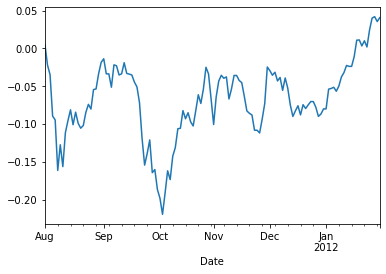

In [22]:
# Sanity check to make sure calculation is correct
returns['USA_EPU'].cumsum().plot()

In [23]:
# Reallocate capital and rebalance
position_size = capital / 60
position_size

1666.6484643908286

In [24]:
# Use new allocations to calculate next period
returns2 = semiannual[2][top15[2]] * position_size
returns2

,USA_CNY=X,USA_JPY=X,USA_RUB=X,USA_BRL=X,USA_ZAR=X,USA_EUR=X,USA_KXI,USA_ACWV,USA_MXN=X,USA_EPHE,...,CAN_XHY.TO,CAN_HXT.TO,CAN_XBM.TO,CAN_XUU.TO,CAN_XDG.TO,CAN_XDGH.TO,CAN_XGGB.TO,CAN_CLG.TO,CAN_CBH.TO,CAN_XSE.TO
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-31,-2.740851,-8.079983,13.083646,7.959253,18.251904,8.805434,-2.534827,0.790818,11.019015,25.986512,...,2.763928,-1.605634,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-01,-1.319888,-1.964358,-16.573130,-1.431583,-7.749675,7.883241,16.501470,15.413633,-21.535632,42.184878,...,2.759352,6.428731,10.700793,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-02,-0.475536,-1.770008,4.270869,-12.513236,-27.763928,-11.769193,-1.885349,1.566399,-12.163995,28.328303,...,1.377395,4.803022,14.619723,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-03,-0.687082,-0.196877,1.847824,-13.089114,-5.307521,4.170462,14.470711,7.824641,-17.285152,8.621739,...,2.752516,4.789220,18.445121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-06,0.105748,8.116652,0.817889,-2.716149,-21.123333,1.313701,-3.742474,-12.460923,0.658609,-3.958785,...,0.000000,-3.183665,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-07-25,0.391471,-4.341616,15.288337,7.447702,12.242592,8.688880,0.000000,7.577397,-13.312277,4.907320,...,-4.012797,3.432850,-3.638970,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
2012-07-26,0.260919,-0.085352,-13.387345,-10.429284,-22.016880,-10.855026,40.103360,20.743531,-24.155036,23.241336,...,16.089929,22.267657,12.764266,NaN,NaN,NaN,NaN,-4.365811,-2.276842,NaN
2012-07-27,-1.173953,4.715943,-18.977759,-10.330974,-30.720625,-19.019662,24.763609,18.253414,-21.301922,20.508884,...,7.968040,16.903128,54.288224,NaN,NaN,NaN,NaN,-6.565916,-7.979849,NaN


In [25]:
# Concatenate to get continuous stream
pd.concat([returns, returns2])

,USA_JPY=X,USA_ZAR=X,USA_RUB=X,USA_BRL=X,USA_EUR=X,USA_CNY=X,USA_EPU,USA_TUR,USA_EPHE,USA_ECH,...,CAN_XDGH.TO,CAN_XGGB.TO,CAN_CLG.TO,CAN_CBH.TO,CAN_XSE.TO,CAN_XFR.TO,USA_KXI,USA_ACWV,USA_IXJ,USA_EWI
Date,,,,,,,,,,,,,,,,,,,,,
2011-08-01,-0.006651,-0.007357,0.002785,-0.010430,-0.002150,-0.002219,0.005180,-0.006188,0.009129,0.020165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-02,0.003199,0.008252,0.004507,0.007307,0.007182,-0.000482,-0.027197,-0.030212,-0.015625,-0.027369,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-03,-0.001614,0.010074,0.003179,0.003531,0.006275,0.000560,-0.012655,0.021165,0.000835,-0.013722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-04,-0.002884,-0.010607,-0.000783,-0.000192,-0.012613,-0.000342,-0.054844,-0.081509,-0.035476,-0.054244,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-05,0.028245,0.032729,0.014975,0.008829,0.020382,0.000124,-0.005046,-0.038793,0.000000,-0.021043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-07-25,-4.341616,12.242592,15.288337,7.447702,8.688880,0.391471,-5.475846,23.005254,4.907320,-3.213126,...,NaN,NaN,0.000000,0.000000,NaN,0.9208,0.000000,7.577397,9.215276,37.904479
2012-07-26,-0.085352,-22.016880,-13.387345,-10.429284,-10.855026,0.260919,17.980025,66.860442,23.241336,-5.472865,...,NaN,NaN,-4.365811,-2.276842,NaN,0.0000,40.103360,20.743531,24.220736,108.938613
2012-07-27,4.715943,-30.720625,-18.977759,-10.330974,-19.019662,-1.173953,24.211614,38.958590,20.508884,19.702627,...,NaN,NaN,-6.565916,-7.979849,NaN,0.0000,24.763609,18.253414,30.326163,80.117194


In [26]:
# Generalize to all time periods

capital = 100000
dollar_full_portfolio = pd.DataFrame()
pct_full_portfolio = pd.DataFrame()
PnL = {}

for i in range(1,len(semiannual.keys())):
    position_size = capital / 60
    returns = semiannual[i][top15[i]]
    
    
    # Remove an outlier
    returns[returns.values > 100] = 0
    
    pct_full_portfolio = pd.concat([pct_full_portfolio, returns])
    dollar_full_portfolio = pd.concat([dollar_full_portfolio, returns*position_size])
    
    capital += sum(returns.iloc[-1,:])
    
    PnL[i] = returns.sum(axis=1)

<ipython-input-26-c4d6d6c9ba84>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns[returns.values > 100] = 0
/Users/apple/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3089: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


In [27]:
dollar_full_portfolio = dollar_full_portfolio

<AxesSubplot:xlabel='Date'>

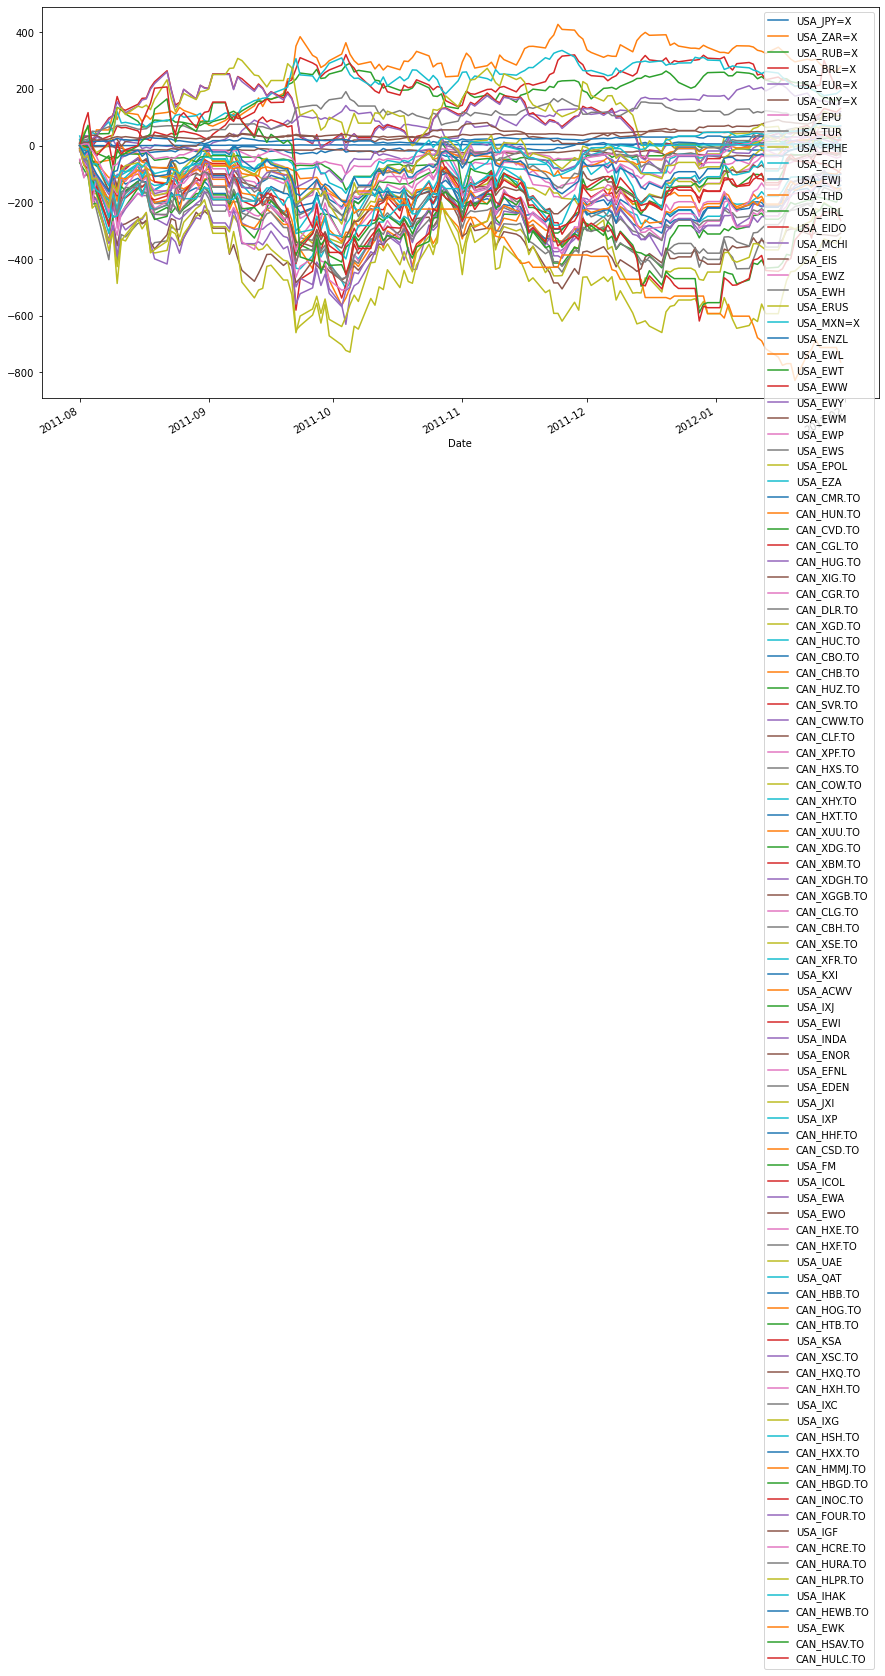

In [28]:
dollar_full_portfolio.cumsum().plot(figsize = (15,8))

<AxesSubplot:xlabel='None,Date'>

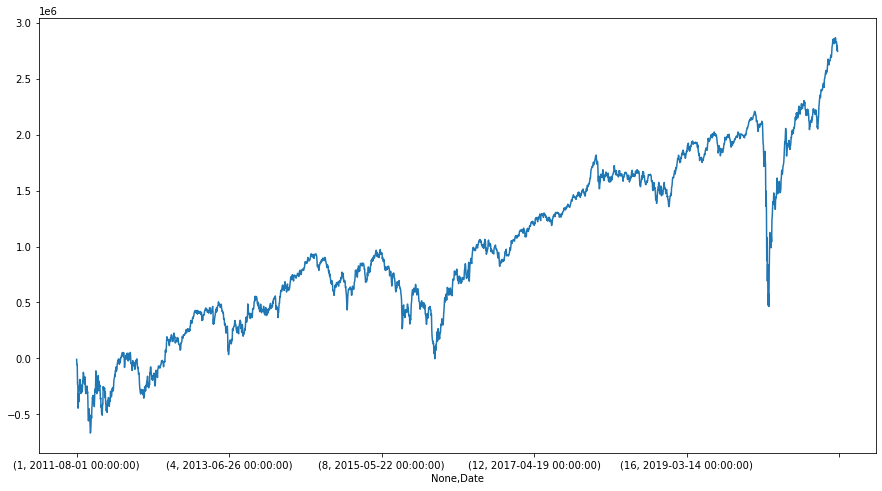

In [29]:
# PnL of whole portfolio 
(pd.concat(PnL)* 100000).cumsum().plot(figsize=(15,8))

In [30]:
PnL[1]

Date
2011-08-01   -0.089906
2011-08-02   -0.468501
2011-08-03    0.004559
2011-08-04   -1.765713
2011-08-05   -0.107292
                ...   
2012-01-25    0.530779
2012-01-26    0.015550
2012-01-27    0.288790
2012-01-30   -0.418279
2012-01-31    0.097058
Length: 132, dtype: float64

In [31]:
import importlib
import Risk_analytics
importlib.reload(Risk_analytics)
from Risk_analytics import risk
returns 


,USA_BRL=X,USA_EUR=X,USA_JPY=X,USA_ZAR=X,USA_RUB=X,USA_MXN=X,USA_CNY=X,USA_QAT,USA_UAE,USA_KSA,...,CAN_FOUR.TO,CAN_HULC.TO,CAN_DLR.TO,CAN_CVD.TO,CAN_HUC.TO,CAN_CBO.TO,CAN_XSC.TO,CAN_XHY.TO,CAN_HLPR.TO,CAN_HMMJ.TO
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-31,-0.002883,-0.007541,-0.003323,0.010690,0.011669,0.001042,0.001000,-0.004846,-0.009891,-0.004131,...,0.017735,0.000000,-0.004412,-0.003019,0.004193,0.000536,0.001542,0.010870,0.001596,-0.019858
2020-08-03,0.013058,0.007598,0.011301,0.017776,0.014095,0.012057,-0.004724,0.000000,0.009990,-0.005656,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-08-04,0.018674,0.001650,0.001549,0.009611,-0.017730,0.016401,0.000746,0.003043,0.000000,0.004551,...,0.016354,0.016610,-0.005170,-0.000606,0.018789,0.001071,0.000000,-0.004527,0.001062,0.047757
2020-08-05,-0.005358,-0.004352,-0.003923,0.009682,0.004822,0.000119,-0.000960,0.003641,-0.000989,0.011325,...,0.012134,0.003543,-0.003712,-0.000606,0.014344,-0.000535,-0.000513,0.004548,0.004244,-0.013812
2020-08-06,0.000132,-0.004844,-0.000578,-0.001625,-0.007828,-0.011349,-0.005464,0.006651,0.000990,0.007465,...,-0.002346,0.002452,0.002235,0.000000,0.005051,0.000000,0.001540,0.002264,-0.001585,-0.040616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,0.021684,-0.000243,0.002618,0.012579,0.018489,0.010427,0.003002,-0.003778,0.003152,-0.003818,...,-0.005673,0.002089,0.001558,0.003895,0.006404,0.000528,0.000506,-0.004860,0.004507,-0.037104
2021-01-26,0.000000,0.001947,-0.000164,0.005359,-0.000434,0.008138,-0.000324,-0.003792,-0.012569,-0.005110,...,-0.001630,0.000000,-0.004666,0.006652,-0.004545,-0.000528,-0.000506,0.001085,0.000449,0.044173
2021-01-27,-0.020437,-0.001336,-0.001513,-0.011305,-0.002817,-0.005814,-0.002315,0.002175,-0.000796,-0.005136,...,-0.030204,0.000000,0.009375,-0.000551,0.000913,-0.000528,0.000000,-0.004336,-0.001345,0.009901


In [32]:
pd.DataFrame(np.cov(returns))

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,0.000173,-0.000005,0.000075,0.000039,0.000121,-0.000041,1.457969e-05,-0.000254,-0.000037,0.000151,...,0.000001,0.000020,0.000036,1.721951e-05,-0.000004,0.000034,-0.000024,0.000020,0.000092,0.000052
1,-0.000005,0.000068,-0.000011,-0.000011,-0.000022,0.000004,7.754371e-07,0.000022,-0.000012,-0.000007,...,0.000006,0.000039,-0.000007,-6.917945e-06,0.000029,0.000039,0.000016,0.000001,-0.000007,0.000022
2,0.000075,-0.000011,0.000294,0.000069,0.000125,-0.000106,9.586894e-05,-0.000329,0.000015,0.000178,...,0.000022,0.000024,0.000021,-1.806121e-06,-0.000030,-0.000023,0.000026,-0.000052,0.000146,0.000010
3,0.000039,-0.000011,0.000069,0.000126,0.000105,-0.000035,1.894206e-05,-0.000156,0.000036,0.000109,...,-0.000009,-0.000006,0.000036,1.103351e-05,-0.000039,-0.000003,-0.000010,-0.000021,0.000037,-0.000014
4,0.000121,-0.000022,0.000125,0.000105,0.000268,-0.000037,3.316934e-05,-0.000338,-0.000002,0.000210,...,-0.000008,0.000010,0.000060,3.544815e-05,-0.000064,0.000019,-0.000035,0.000010,0.000106,0.000072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.000034,0.000039,-0.000023,-0.000003,0.000019,0.000042,-2.373286e-05,0.000026,-0.000033,-0.000002,...,0.000011,-0.000004,-0.000006,-9.785720e-07,0.000033,0.000117,-0.000029,0.000022,-0.000038,0.000030
127,-0.000024,0.000016,0.000026,-0.000010,-0.000035,-0.000010,2.676429e-05,-0.000022,-0.000008,0.000014,...,0.000013,-0.000021,-0.000021,2.310619e-06,0.000013,-0.000029,0.000070,0.000014,0.000003,-0.000005
128,0.000020,0.000001,-0.000052,-0.000021,0.000010,0.000052,-2.027059e-05,-0.000019,-0.000054,0.000023,...,0.000028,-0.000027,-0.000058,2.171553e-05,0.000071,0.000022,0.000014,0.000246,-0.000102,0.000073
129,0.000092,-0.000007,0.000146,0.000037,0.000106,-0.000063,8.836042e-05,-0.000248,0.000006,0.000139,...,-0.000004,0.000052,0.000027,-3.027334e-06,-0.000034,-0.000038,0.000003,-0.000102,0.000221,0.000023


In [33]:
import importlib
import Risk_analytics
importlib.reload(Risk_analytics)
from Risk_analytics import risk
risk_profile = risk(returns,np.ones(60),60)
risk_profile

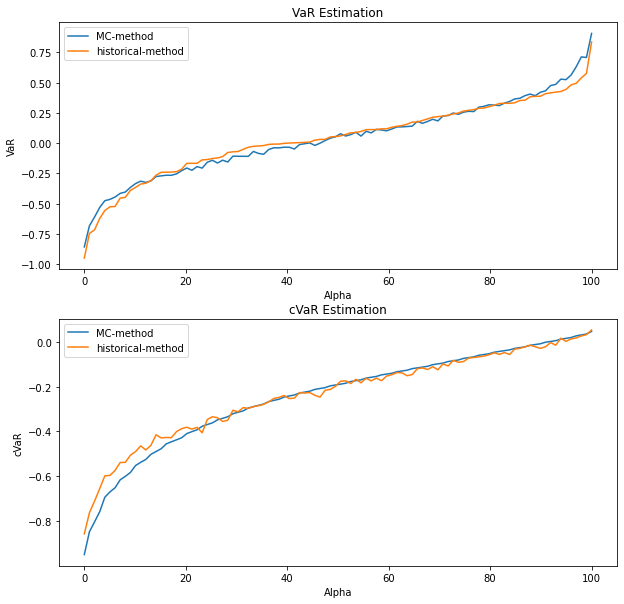

In [34]:
risk_profile.plot_VaR(1000)

In [35]:
risk_profile.max_drawdown()

-0.9993894442305067

In [36]:
risk_profile.sharpe_ratio(0.02)

0.008884318720412144

# Optimized weight for cutoff 30-ETFs

In [90]:
import portfolio_optimization

importlib.reload(portfolio_optimization)

from portfolio_optimization import portfolio_optimization

In [91]:
# single period check:
# calculate position size using four different optimization alogs (separate US and CA as 50/50)
returns_US = semiannual[10][top15[2][:30]].fillna(0)
returns_CA = semiannual[10][top15[2][30:]].fillna(0)

returns_fact = semiannual[10][top15[1]].fillna(0)

portfolio_optimizer_CA = portfolio_optimization(returns_CA, returns_fact)

w_MVO = portfolio_optimizer_CA.CVaR_optimization()
print(len(w_MVO))

30


In [92]:
# calculate the optimal weights using different optimization algos

capital = 100000
capital_US = capital/2
capital_CA = capital/2

dollar_full_portfolio_MVO = pd.DataFrame()
pct_full_portfolio_MVO = pd.DataFrame()
PnL_MVO = {}

dollar_full_portfolio_robustMVO = pd.DataFrame()
pct_full_portfolio_robustMVO = pd.DataFrame()
PnL_robustMVO = {}

dollar_full_portfolio_rp = pd.DataFrame()
pct_full_portfolio_rp = pd.DataFrame()
PnL_rp = {}

dollar_full_portfolio_cvar = pd.DataFrame()
pct_full_portfolio_cvar = pd.DataFrame()
PnL_cvar = {}

for i in range(1,len(semiannual.keys())):
    
    semiannual[i] = semiannual[i].fillna(0)
    # calculate position size using four different optimization alogs (separate US and CA as 50/50)
    returns_US = semiannual[i][top15[i][:30]]
    returns_CA = semiannual[i][top15[i][30:]]
    
    # use all low correlated assets as factors
    factorReturns = semiannual[i][top15[i]]
    
    # US ETFs
    portfolio_optimizer_US = portfolio_optimization(returns_US, factorReturns)
    
    w_MVO = portfolio_optimizer_US.MVO()
    w_robustMVO = portfolio_optimizer_US.robust_MVO()
    w_rp = portfolio_optimizer_US.Risk_parity()
    w_cvar = portfolio_optimizer_US.CVaR_optimization()
    
    position_MVO_US = capital_US * w_MVO
    position_robustMVO_US = capital_US * w_robustMVO
    position_rp_US = capital_US * w_rp
    position_cvar_US = capital_US * w_cvar
    
    # CA ETFs
    portfolio_optimizer_CA = portfolio_optimization(returns_CA, factorReturns)
    
    w_MVO = portfolio_optimizer_CA.MVO()
    w_robustMVO = portfolio_optimizer_CA.robust_MVO()
    w_rp = portfolio_optimizer_CA.Risk_parity()
    w_cvar = portfolio_optimizer_CA.CVaR_optimization()
    
    position_MVO_CA = capital_CA * w_MVO
    position_robustMVO_CA = capital_CA * w_robustMVO
    position_rp_CA = capital_CA * w_rp
    position_cvar_CA = capital_CA * w_cvar
    
    pct_full_portfolio = pd.concat([pct_full_portfolio, pd.concat([returns_US, returns_CA], axis=1)])
    dollar_full_portfolio_MVO = pd.concat([dollar_full_portfolio_MVO, 
                                           pd.concat([returns_US.multiply(position_MVO_US, axis=1), 
                                                      returns_CA.multiply(position_MVO_CA, axis=1)], axis=1)])
    dollar_full_portfolio_robustMVO = pd.concat([dollar_full_portfolio_robustMVO, 
                                                 pd.concat([returns_US.multiply(position_robustMVO_US, axis=1), 
                                                      returns_CA.multiply(position_robustMVO_CA, axis=1)], axis=1)])
    dollar_full_portfolio_rp = pd.concat([dollar_full_portfolio_rp, 
                                           pd.concat([returns_US.multiply(position_rp_US, axis=1), 
                                                      returns_CA.multiply(position_rp_CA, axis=1)], axis=1)])
    dollar_full_portfolio_cvar = pd.concat([dollar_full_portfolio_cvar, 
                                           pd.concat([returns_US.multiply(position_cvar_US, axis=1), 
                                                      returns_CA.multiply(position_cvar_CA, axis=1)], axis=1)])
    
    PnL_MVO[i] = dollar_full_portfolio_MVO.sum(axis=1)
    PnL_robustMVO[i] = dollar_full_portfolio_robustMVO.sum(axis=1)
    PnL_rp[i] = dollar_full_portfolio_rp.sum(axis=1)
    PnL_cvar[i] = dollar_full_portfolio_cvar.sum(axis=1)

MVO

<AxesSubplot:xlabel='Date'>

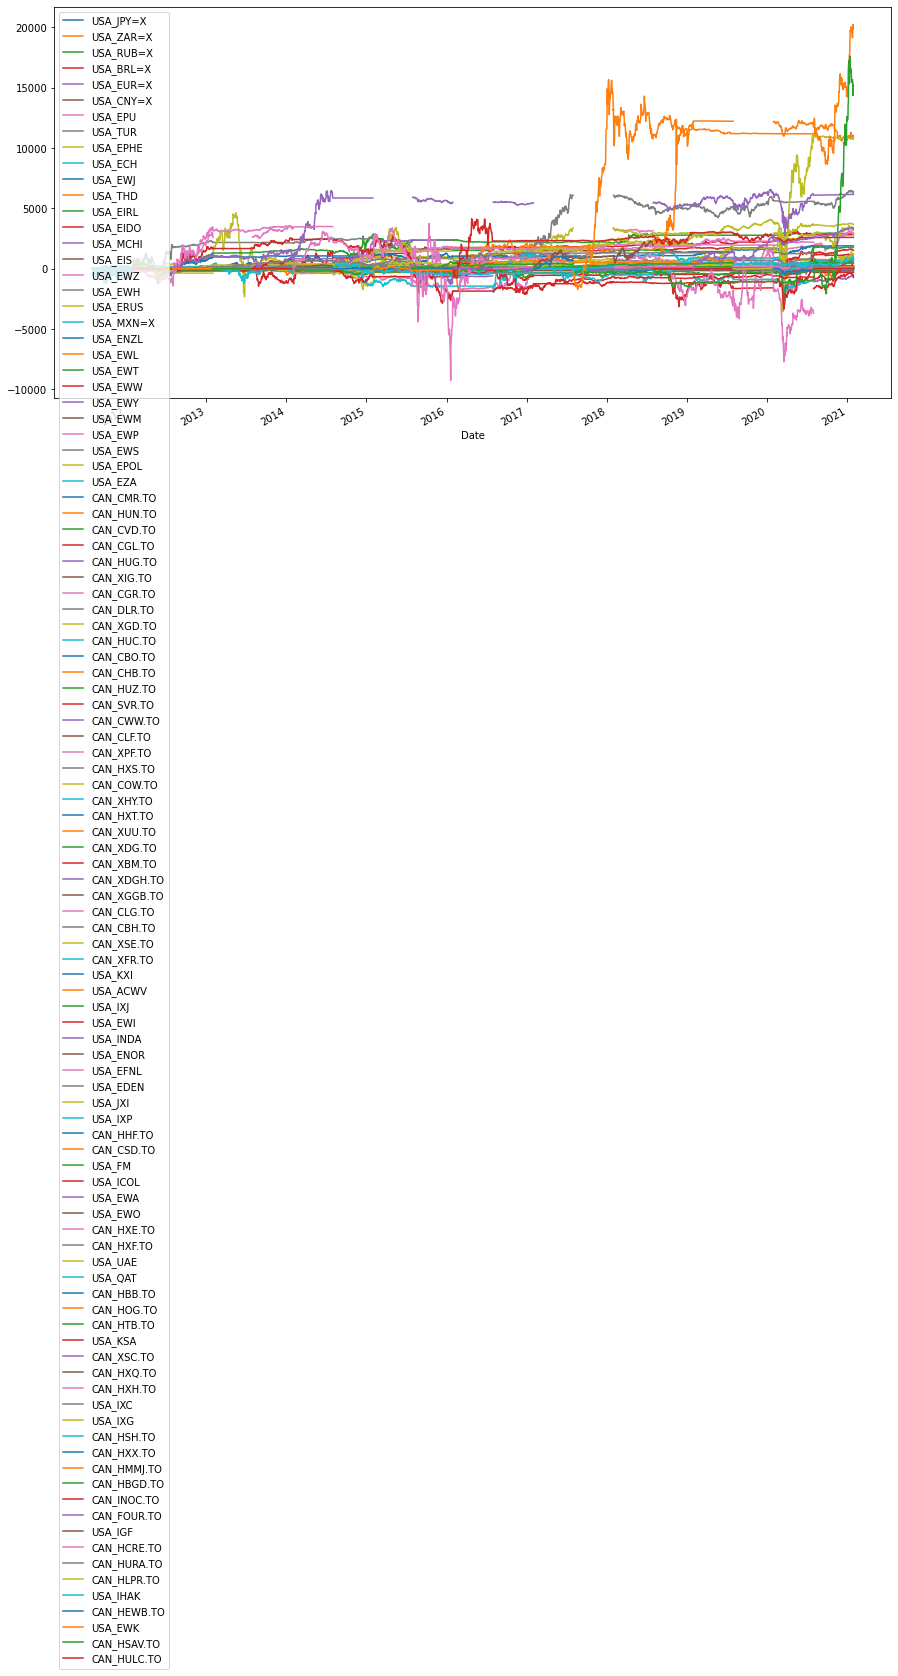

In [93]:
dollar_full_portfolio_MVO.cumsum().plot(figsize = (15,8))

<AxesSubplot:xlabel='None,Date'>

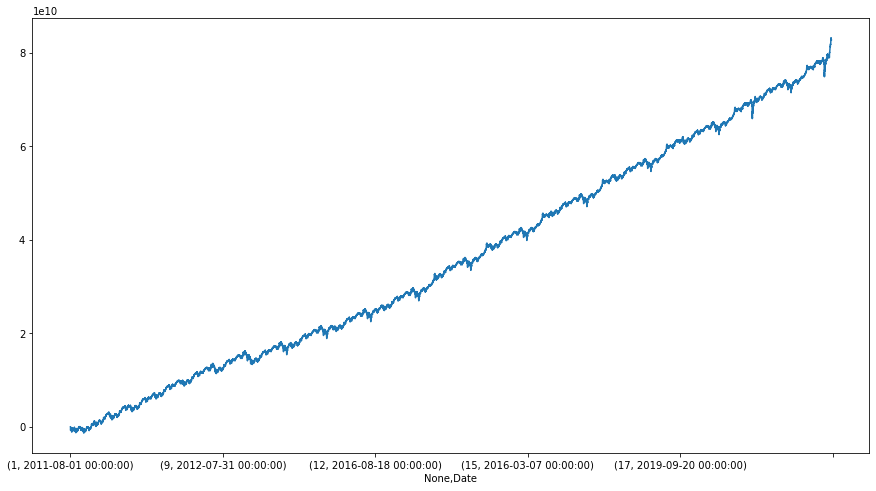

In [94]:
# PnL of whole portfolio 
(pd.concat(PnL_MVO)* 100000).cumsum().plot(figsize=(15,8))

In [ ]:
risk_profile = risk(returns,np.ones(60),60)
risk_profile.plot_VaR(1000)
risk_profile.max_drawdown()
risk_profile.sharpe_ratio(0.02)

ROBUST MVO

<AxesSubplot:xlabel='Date'>

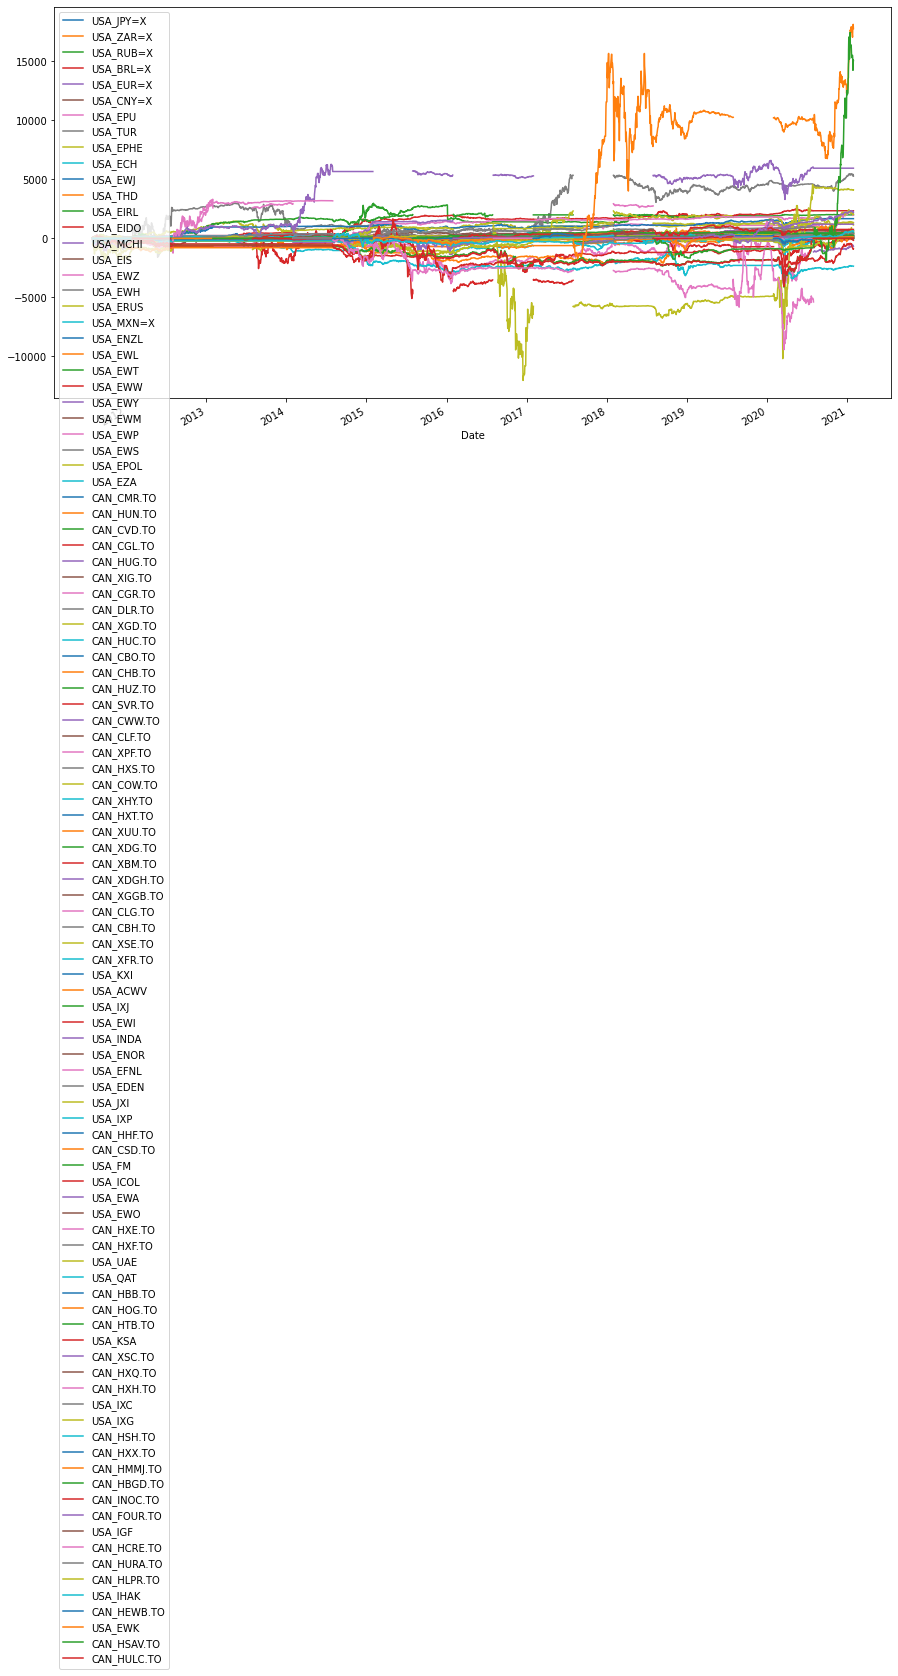

In [96]:
dollar_full_portfolio_robustMVO.cumsum().plot(figsize = (15,8))